In [1]:
#安装相应package
#!pip install numpy pandas matplotlib requests tqdm opencv-python 
# !pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
#测试torch
# import torch 
# torch.__version__

In [3]:
#中文字体文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf --no-check-certificate

--2023-04-01 17:35:21--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在解析主机 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
正在连接 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “SimHei.ttf.4”

SimHei.ttf.4        100%[===================>]   9.58M  35.3MB/s    用时 0.3s    

2023-04-01 17:35:21 (35.3 MB/s) - 已保存 “SimHei.ttf.4” [10050868/10050868])



In [4]:
import os

In [5]:

# 存放结果文件
os.mkdir('output')

# 存放训练得到的模型权重
os.mkdir('checkpoint')


# 存放生成的图表
os.mkdir('图表')

# 准备数据集

In [6]:
# !git clone https://github.com/JasonYangCode/AppleLeaf9

# 导入工具包

In [7]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


# 图像预处理

In [8]:
from torchvision import transforms
target_size = (224,224)
# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.Resize(target_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])


# 加载数据集

In [9]:
# 数据集文件夹路径
dataset_dir = 'AppleLeaf9_split'
#训练集路径
train_path = os.path.join(dataset_dir, 'train')
#测试集路径
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 AppleLeaf9_split/train
测试集路径 AppleLeaf9_split/val


In [10]:
from torchvision import datasets
#是否输入train_transform、test_transform参数可以选择是否对训练集和测试集进行数据增强，目前是未进行数据增强
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集图像数量 11669
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']
测试集图像数量 2913
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']


In [11]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 2913
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']


In [12]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)
class_names

['Alternaria leaf spot',
 'Brown spot',
 'Frogeye leaf spot',
 'Grey spot',
 'Health',
 'Mosaic',
 'Powdery mildew',
 'Rust',
 'Scab']

In [13]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'Alternaria leaf spot': 0,
 'Brown spot': 1,
 'Frogeye leaf spot': 2,
 'Grey spot': 3,
 'Health': 4,
 'Mosaic': 5,
 'Powdery mildew': 6,
 'Rust': 7,
 'Scab': 8}

In [14]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
idx_to_labels

{0: 'Alternaria leaf spot',
 1: 'Brown spot',
 2: 'Frogeye leaf spot',
 3: 'Grey spot',
 4: 'Health',
 5: 'Mosaic',
 6: 'Powdery mildew',
 7: 'Rust',
 8: 'Scab'}

# 定义数据加载器

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

# 查看一个batch中的img和label


In [16]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [17]:
images.shape

torch.Size([32, 3, 224, 224])

In [18]:
labels

tensor([2, 8, 8, 8, 7, 2, 8, 2, 7, 7, 8, 2, 4, 8, 6, 6, 8, 7, 8, 8, 8, 2, 7, 7,
        8, 2, 8, 8, 7, 8, 8, 2])

# 可视化一个batch的图像和标注

In [19]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:8')

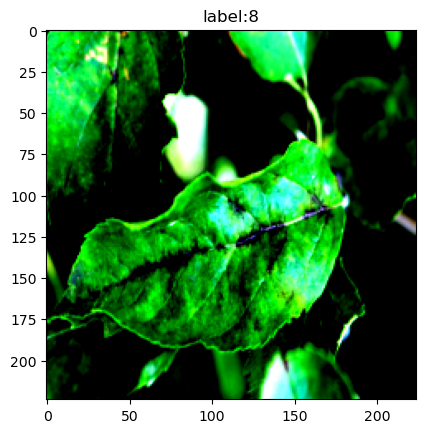

In [20]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [21]:
# 显示类别数字
label = labels[idx].item()
label

8

In [22]:
# 显示类别数字对应的类别
pred_classname = idx_to_labels[label]
pred_classname

'Scab'

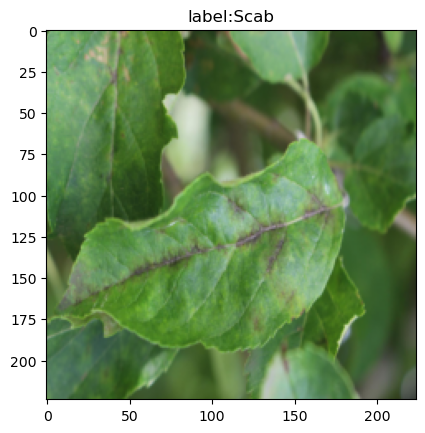

In [23]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

# 导入train所需包

In [24]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

# CBAM

In [25]:
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import math

## 以下是CBAM代码
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F

class ChannelAttentionModule(nn.Module):
    def __init__(self, channel, ratio=16):
        super(ChannelAttentionModule, self).__init__()
        #使用自适应池化缩减map的大小，保持通道不变
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channel, channel // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // ratio, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avgout = self.shared_MLP(self.avg_pool(x))
        maxout = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)
 
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        #map尺寸不变，缩减通道
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avgout, maxout], dim=1)
        out = self.sigmoid(self.conv2d(out))
        return out
 
class CBAM(nn.Module):
    def __init__(self, channel):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttentionModule(channel)
        self.spatial_attention = SpatialAttentionModule()
 
    def forward(self, x):
        out = self.channel_attention(x) * x
        out = self.spatial_attention(out) * out
        return out


class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA,self).__init__()
        # 第二个分支
        self.branch1_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        # 第三个分支
        self.branch5_5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5_5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        # 第四个分支
        self.branch3_3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3_3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3_3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        # 第一个分支
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
    def forward(self, x):

        branch1_1 = self.branch1_1(x)
        
        branch5_5 = self.branch5_5_1(x)
        branch5_5 = self.branch5_5_2(branch5_5)
        
        branch3_3 = self.branch3_3_1(x)
        branch3_3 = self.branch3_3_2(branch3_3)
        branch3_3 = self.branch3_3_3(branch3_3)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1_1, branch5_5, branch3_3, branch_pool]
        return torch.cat(outputs, dim=1) # (b, c, w, h),则dim=1，即按照通道进行拼接。


In [26]:
cbam_custom_64 = CBAM(256)



# 迁移学习模型设置

In [27]:
model = models.resnet50(pretrained=True) # 载入预训练模型
# 加入CBAM
model.layer1 = nn.Sequential(model.layer1[0],cbam_custom_64,model.layer1[1],cbam_custom_64)
model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 训练参数配置

In [29]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.NLLLoss()

# 训练轮次 Epoch
EPOCHS = 30

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 训练集上训练

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

m = nn.LogSoftmax(dim=1)

def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    
    loss = criterion(m(outputs), labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    log_train['train_precision'] = precision_score(labels, preds, average='macro')
    log_train['train_recall'] = recall_score(labels, preds, average='macro')
    log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

# 测试集上测试

In [31]:
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

# 训练集之前，记录训练日志

In [32]:
import pandas as pd
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [33]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [34]:
df_train_log

,epoch,batch,train_loss,train_accuracy,train_precision,train_recall,train_f1-score
0,0.0,0.0,2.0450506,0.3125,0.156224,0.146032,0.129881


In [35]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [36]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,-0.8705,0.243392,0.194769,0.107496,0.091162


# 安装wandb


In [37]:
import wandb

wandb.init(project='appleleaf', name=time.strftime('%m%d%H%M%S'))

wandb: Currently logged in as: pet. Use `wandb login --relogin` to force relogin


# 开始训练

In [38]:
for epoch in range(1, EPOCHS+1):
    
    print(f'Epoch {epoch}/{EPOCHS}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

Epoch 1/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.28it/s]


保存新的最佳模型 checkpoint/best-0.801.pth
Epoch 2/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


保存新的最佳模型 checkpoint/best-0.867.pth
Epoch 3/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


保存新的最佳模型 checkpoint/best-0.888.pth
Epoch 4/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


保存新的最佳模型 checkpoint/best-0.907.pth
Epoch 5/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 6/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


保存新的最佳模型 checkpoint/best-0.936.pth
Epoch 7/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.23it/s]


Epoch 8/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


保存新的最佳模型 checkpoint/best-0.938.pth
Epoch 9/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.26it/s]


Epoch 10/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


保存新的最佳模型 checkpoint/best-0.942.pth
Epoch 11/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.26it/s]


保存新的最佳模型 checkpoint/best-0.956.pth
Epoch 12/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 13/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.23it/s]


Epoch 14/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 15/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 16/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.27it/s]


保存新的最佳模型 checkpoint/best-0.958.pth
Epoch 17/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 18/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 19/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.22it/s]


Epoch 20/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 21/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.26it/s]


Epoch 22/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


Epoch 23/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 24/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


Epoch 25/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


Epoch 26/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.24it/s]


Epoch 27/30


100%|████████████████████████████████████████| 365/365 [01:09<00:00,  5.25it/s]


Epoch 28/30


100%|████████████████████████████████████████| 365/365 [01:20<00:00,  4.52it/s]


保存新的最佳模型 checkpoint/best-0.959.pth
Epoch 29/30


100%|████████████████████████████████████████| 365/365 [01:24<00:00,  4.32it/s]


Epoch 30/30


100%|████████████████████████████████████████| 365/365 [01:06<00:00,  5.52it/s]


# 可视化训练日志

In [39]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
df_train = pd.read_csv('训练日志-训练集.csv')
df_test = pd.read_csv('训练日志-测试集.csv')
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
# pd.set_option('display.max_rows', None)

In [52]:
df_train

NameError: name 'dt_train' is not defined

In [49]:
df

    epoch  test_loss  test_accuracy  test_precision  test_recall  \
0     0.0  -0.870500       0.243392        0.194769     0.107496   
1     1.0  -5.019037       0.800549        0.781349     0.702634   
2     2.0  -6.232886       0.867491        0.830148     0.781849   
3     3.0  -5.821624       0.888431        0.809289     0.867824   
4     4.0  -6.160504       0.907312        0.880845     0.850106   
5     5.0  -6.416641       0.854102        0.826328     0.849561   
6     6.0  -6.448018       0.935805        0.919730     0.894498   
7     7.0  -6.611806       0.931342        0.889815     0.904767   
8     8.0  -8.030117       0.937521        0.904932     0.890573   
9     9.0  -6.413738       0.931342        0.877406     0.912533   
10   10.0  -7.597535       0.941641        0.910269     0.920188   
11   11.0  -7.988407       0.955716        0.928806     0.937244   
12   12.0  -8.760812       0.953313        0.936204     0.929710   
13   13.0  -8.919532       0.941641        0.929

# 训练集的准确率和损失函数

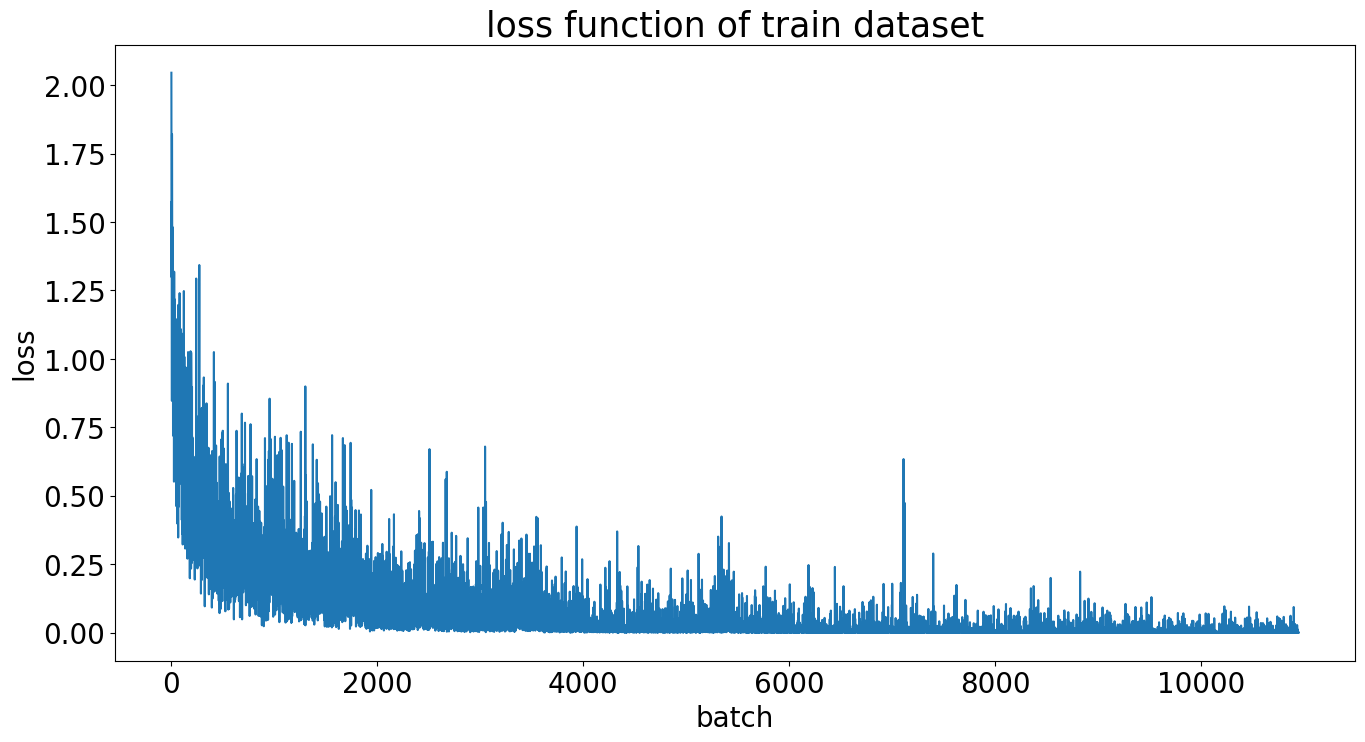

In [43]:
plt.figure(figsize=(16, 8))

x = df_train['batch']
y = df_train['train_loss']

plt.plot(x, y, label='train dataset')

plt.tick_params(labelsize=20)
plt.xlabel('batch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('loss function of train dataset', fontsize=25)
plt.savefig('图表/训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

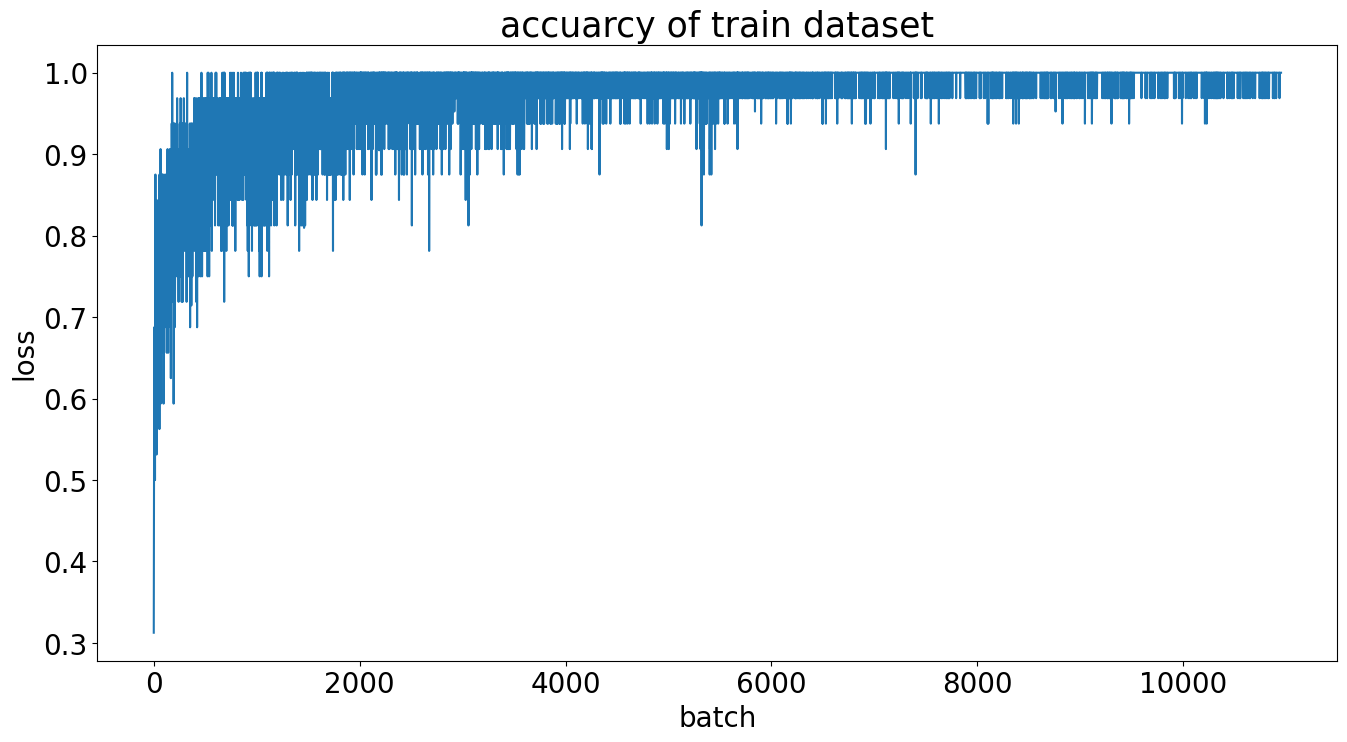

In [44]:
plt.figure(figsize=(16, 8))

x = df_train['batch']
y = df_train['train_accuracy']

plt.plot(x, y, label='训练集')

plt.tick_params(labelsize=20)
plt.xlabel('batch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('accuarcy of train dataset', fontsize=25)
plt.savefig('图表/训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.show()

# 验证集损失函数

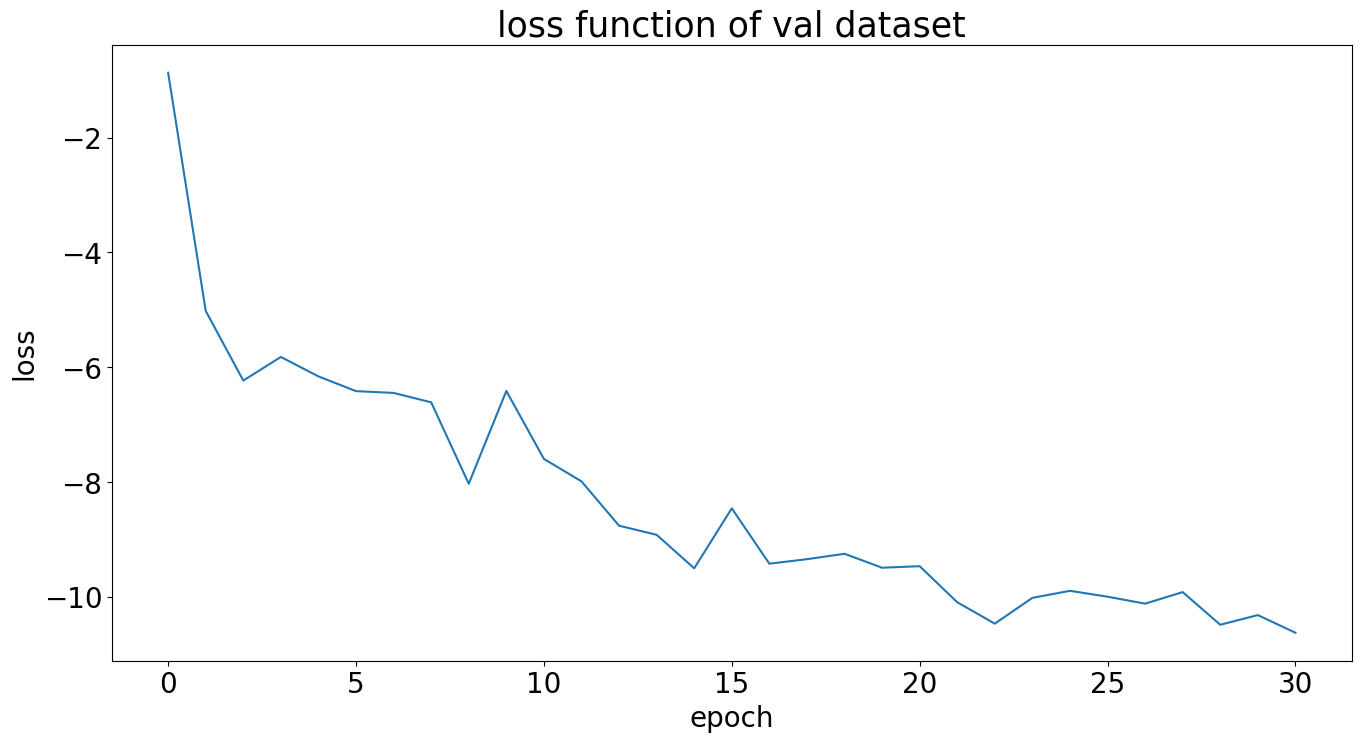

In [45]:
plt.figure(figsize=(16, 8))

x = df_test['epoch']
y = df_test['test_loss']

plt.plot(x, y, label='测试集')

plt.tick_params(labelsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('loss function of val dataset', fontsize=25)
plt.savefig('图表/测试集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

# 验证集集评估指标

In [46]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg


In [47]:
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1-score']

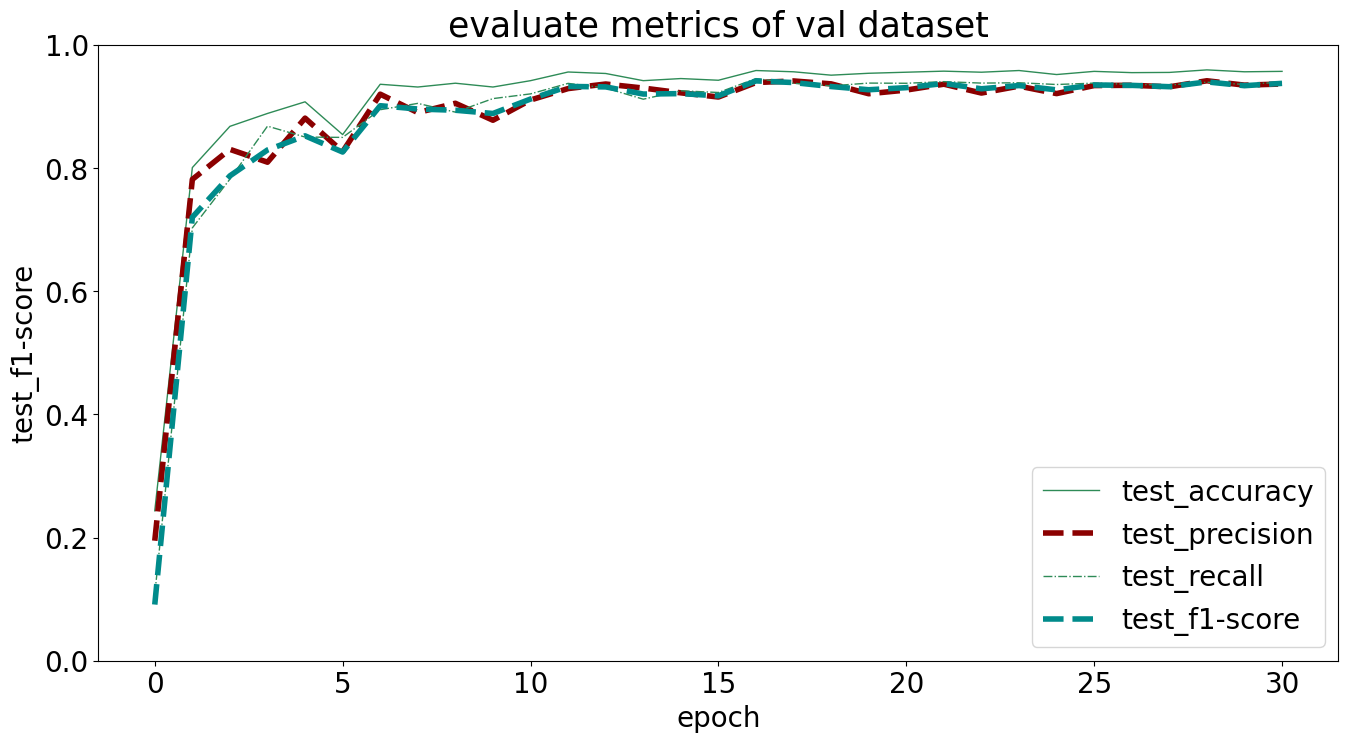

In [48]:
plt.figure(figsize=(16, 8))

x = df_test['epoch']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.ylim([0, 1])
plt.xlabel('epoch', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('evaluate metrics of val dataset', fontsize=25)
plt.savefig('图表/测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()